### CD4 T cell KO example

This notebook prepares a dataset with 24 individual knockout experiments applied to CD4 T cells ([Freimer et al 2020](https://www.nature.com/articles/s41588-022-01106-y)). Each knockout was profiled with both ATAC and RNA-seq measurements, but we use only RNA. The data have UMI's. Controls are 8 guide RNA's targeting the "safe-harbor" AAVS1 locus, and are labeled `AAVS1_1`, `AAVS1_8`, etc. The experiment was done separately on blood from 3 different donors.

Here we tidy the dataset and carry out a simple exploration in scanpy. (It's not single cell data but scanpy is still useful for data exploration.)

In [42]:
import warnings
warnings.filterwarnings('ignore')
import regex as re
import os
import shutil
import importlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
from scipy.stats import spearmanr as spearmanr
from IPython.display import display, HTML

import os, sys
import itertools as it
from scipy.stats import spearmanr, pearsonr, rankdata, f_oneway
from statsmodels.stats.multitest import multipletests
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# local
import importlib
import sys
sys.path.append("setup")
import ingestion
importlib.reload(ingestion)

#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

# Specify the working directory explicitly.
os.chdir("/home/gary/cahan_rotation/perturbation_data")

### Reshape the data

In [31]:
expression_quantified = pd.read_csv("not_ready/freimer/GSE171677_RNA_UMI_dedup_counts.txt", 
                                    delimiter="\t",
                                    index_col=0, 
                                    header=0, 
                                    comment='!')   
gene_metadata   = expression_quantified.iloc[:,0:5]
expression_quantified = expression_quantified.iloc[:, 5:].T
sample_metadata = pd.DataFrame(columns = ["donor", "perturbation"], 
                               index = expression_quantified.index,
                               data = [g.split("_", maxsplit=2)[1:3] for g in expression_quantified.index])
print("\n\ngene_metadata\n")
display(gene_metadata.head())
print("\n\nsample_metadata\n")
display(sample_metadata.head())
print("\n\n expression_quantified\n")
display(expression_quantified.head().T.head())



gene_metadata



,Chr,Start,End,Strand,Length
Geneid,,,,,
ENSG00000223972.5,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1,11869;12010;12179;12613;12613;12975;13221;1322...,12227;12057;12227;12721;12697;13052;14409;1337...,+;+;+;+;+;+;+;+;+,1735
ENSG00000227232.5,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14404;15005;15796;16607;16858;17233;17606;1791...,14501;15038;15947;16765;17055;17368;17742;1806...,-;-;-;-;-;-;-;-;-;-;-,1351
ENSG00000278267.1,chr1,17369,17436,-,68
ENSG00000243485.5,chr1;chr1;chr1;chr1;chr1,29554;30267;30564;30976;30976,30039;30667;30667;31097;31109,+;+;+;+;+,1021
ENSG00000284332.1,chr1,30366,30503,+,138




sample_metadata



,donor,perturbation
Donor_1_AAVS1_4,1,AAVS1_4
Donor_1_STAT5B,1,STAT5B
Donor_1_AAVS1_7,1,AAVS1_7
Donor_1_TNFAIP3,1,TNFAIP3
Donor_1_MYB,1,MYB




 expression_quantified



,Donor_1_AAVS1_4,Donor_1_STAT5B,Donor_1_AAVS1_7,Donor_1_TNFAIP3,Donor_1_MYB
Geneid,,,,,
ENSG00000223972.5,0,0,0,0,0
ENSG00000227232.5,0,0,0,0,1
ENSG00000278267.1,0,0,0,0,0
ENSG00000243485.5,0,0,0,0,0
ENSG00000284332.1,0,0,0,0,0


### Combine into anndata to keep everything together

In [32]:
expression_quantified = sc.AnnData(expression_quantified, 
                                   var = gene_metadata.copy(),
                                   obs = sample_metadata.copy())
expression_quantified.raw = expression_quantified.copy()
# DRY these up once they're in AnnData
del gene_metadata
del sample_metadata

### Convert ensembl gene id's to gene symbol

In [33]:
expression_quantified.var_names = ingestion.convert_ens_to_symbol(expression_quantified.var_names, gtf = "not_ready/freimer/gencode.v35.annotation.gtf.gz")
display(expression_quantified.var.head())
display(expression_quantified.var_names[0:5])

,Chr,Start,End,Strand,Length
DDX11L1,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1,11869;12010;12179;12613;12613;12975;13221;1322...,12227;12057;12227;12721;12697;13052;14409;1337...,+;+;+;+;+;+;+;+;+,1735
WASH7P,chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;chr1;c...,14404;15005;15796;16607;16858;17233;17606;1791...,14501;15038;15947;16765;17055;17368;17742;1806...,-;-;-;-;-;-;-;-;-;-;-,1351
MIR6859-1,chr1,17369,17436,-,68
MIR1302-2HG,chr1;chr1;chr1;chr1;chr1,29554;30267;30564;30976;30976,30039;30667;30667;31097;31109,+;+;+;+;+,1021
MIR1302-2,chr1,30366,30503,+,138


Index(['DDX11L1', 'WASH7P', 'MIR6859-1', 'MIR1302-2HG', 'MIR1302-2'], dtype='object')

In [34]:
# Document controls with weird names
controls = [f"AAVS1_{i}" for i in range(1,9)]
for c in controls:
    assert c in expression_quantified.obs['perturbation'].unique() 
expression_quantified.obs["is_control"] = expression_quantified.obs['perturbation'].isin(controls)
expression_quantified.obs["is_control_int"] = expression_quantified.obs['perturbation'].isin(controls).astype(int)

### Retain genes w/ a minimum count in at least 3 samples

In [35]:
minCount = np.ceil(10/min(expression_quantified.X.sum(axis=1))/1e-6)
retainColumn = (np.sum(expression_quantified.X > minCount, axis=0) > 3)
expression_quantified._n_vars = np.sum(retainColumn)
expression_quantified.X = expression_quantified.X[:, retainColumn]
expression_quantified.var = expression_quantified.var.iloc[retainColumn]
expression_quantified

AnnData object with n_obs × n_vars = 96 × 14299
    obs: 'donor', 'perturbation', 'is_control', 'is_control_int'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length'

In [36]:
retainRows = ~(expression_quantified.obs.index == 'Donor_4_AAVS1_6')
expression_quantified._n_obs = np.sum(retainRows)
expression_quantified.X = expression_quantified.X[retainRows, :]
expression_quantified.obs = expression_quantified.obs.iloc[retainRows]
expression_quantified

AnnData object with n_obs × n_vars = 95 × 14299
    obs: 'donor', 'perturbation', 'is_control', 'is_control_int'
    var: 'Chr', 'Start', 'End', 'Strand', 'Length'

In [37]:
def RPKM(mat: np.ndarray, geneLength: np.ndarray):
    """
    Expects 
    Args:
        mat: gene expression matrix with shape (n_obs, n_var)
        geneLength: gene length vector with shape (n_var,)
    """
    assert geneLength.shape[0] == mat.shape[1]
    assert geneLength.shape
    return mat * 1e3 * 1e6 / mat.sum(axis=1, keepdims=True) / geneLength[np.newaxis,:]

expression_quantified.X = RPKM(expression_quantified.X + 0.5, expression_quantified.var.Length)

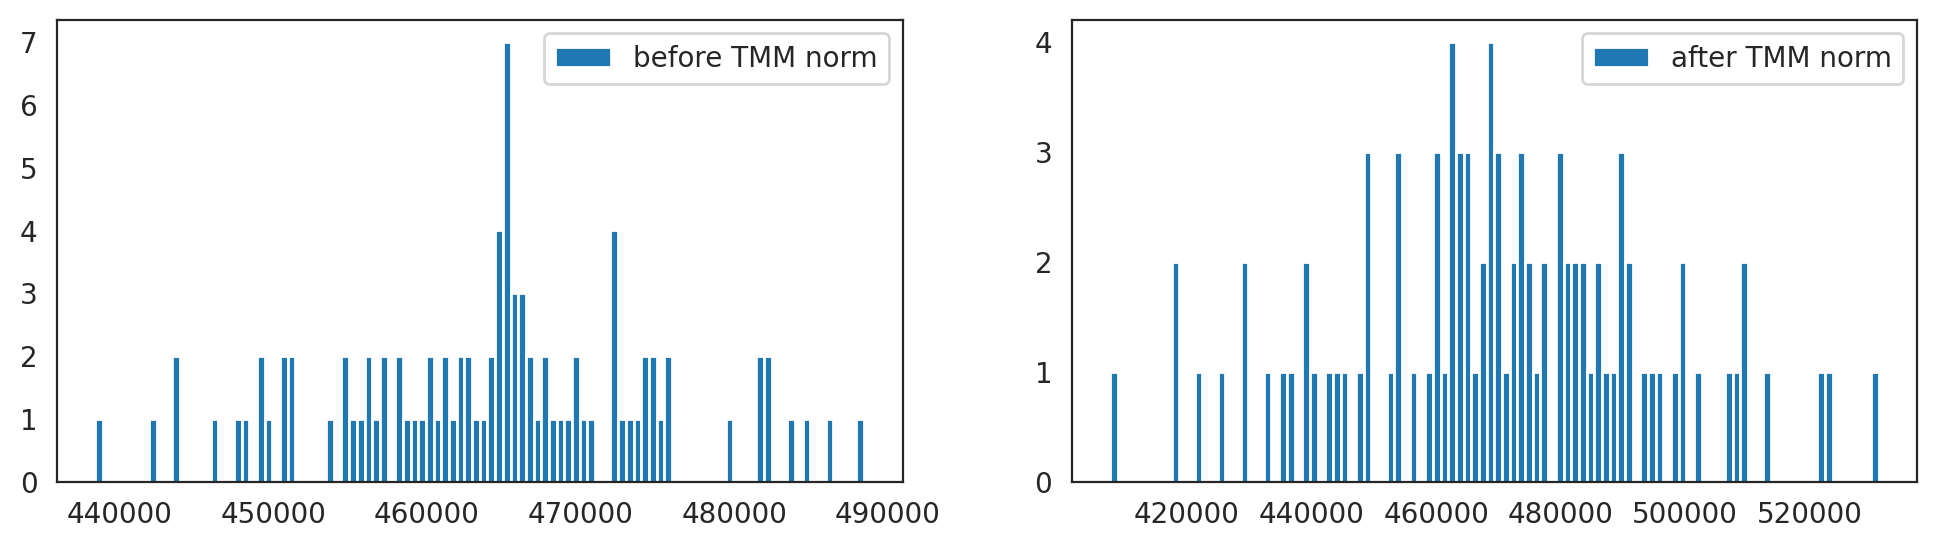

In [38]:
""" The sum of gene expression before and after normalization """
fig, axes = plt.subplots(1, 2, figsize=(12,3))
axes[0].hist(expression_quantified.X.sum(axis=1), bins=100, log=False, label="before TMM norm")
axes[1].hist(ingestion.tmmNormalization(expression_quantified.X.T).T.sum(axis=1), bins=100, log=False, label="after TMM norm")
axes[0].legend()
axes[1].legend()
plt.show()

### Exp

In [43]:
expression_quantified.obs["consistentWithPerturbation"] = ingestion.checkConsistency(expression_quantified, 
                                                                                   perturbationType="knockdown", 
                                                                                   verbose=False, 
                                                                                   group="donor")
Counter(expression_quantified.obs["consistentWithPerturbation"])

Counter({'NA': 23, 'Yes': 58, 'No': 14})

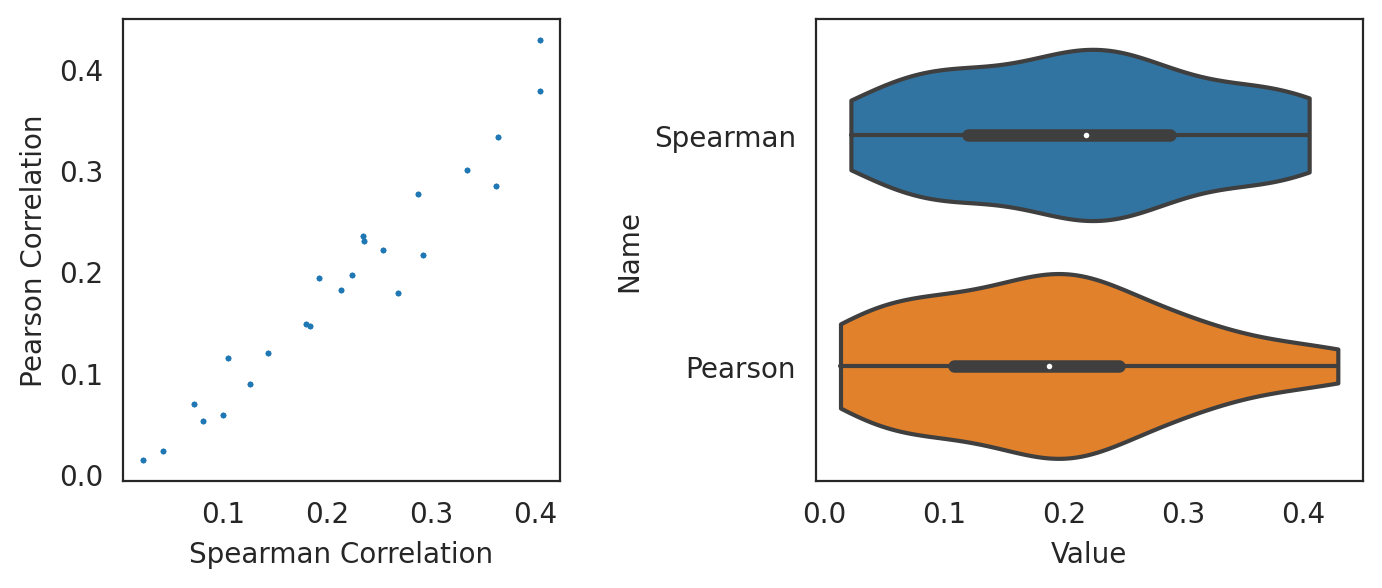

In [44]:
correlations = ingestion.computeCorrelation(expression_quantified, verbose=True, group="donor", diagnostic=False)
expression_quantified.obs["spearmanCorr"] = correlations[0]
expression_quantified.obs[ "pearsonCorr"] = correlations[1]

In [45]:
(diffExprGene,
 mutualInfo,
 logFCMean,
 logFCMse,
 logFCMedian) = ingestion.quantifyEffect(adata=expression_quantified, 
                                         fname="setup/freimer.csv", 
                                         diffExprFC=False) #, group="donor")

(PearsonRResult(statistic=0.9808695652173913, pvalue=3.961519582615096e-17),
 SpearmanrResult(correlation=0.9808695652173912, pvalue=3.9615195826153577e-17))

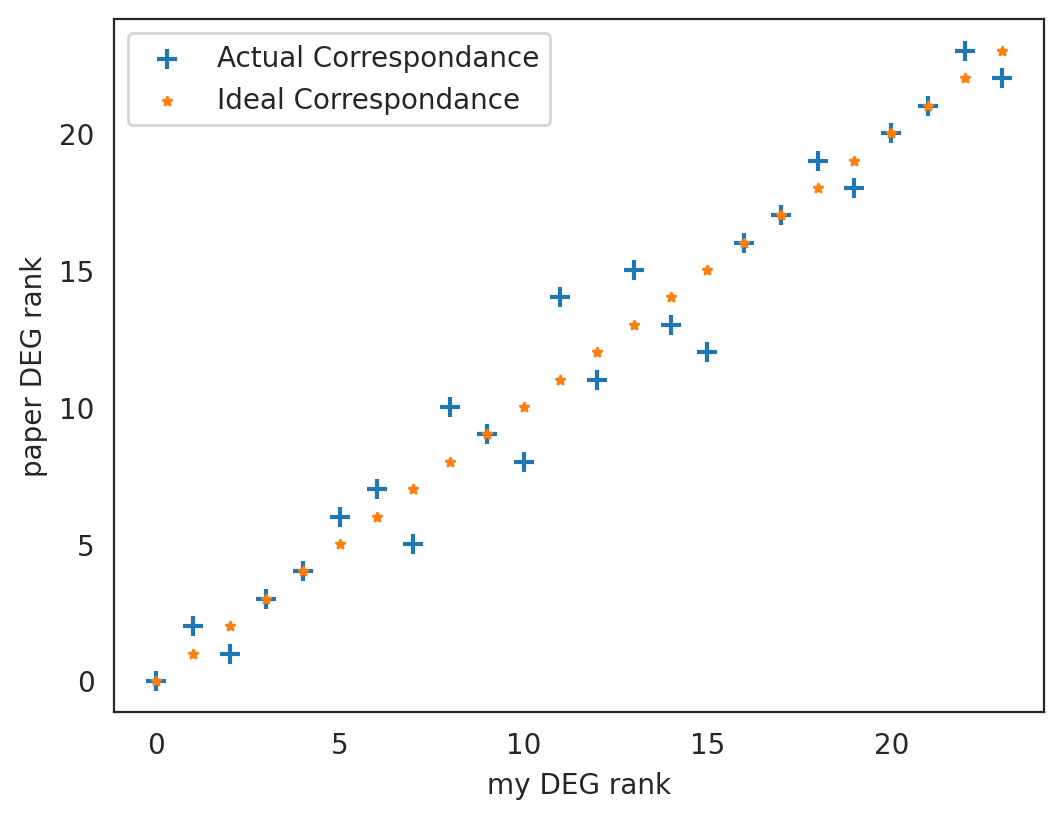

In [46]:
perturbs = sorted(set(expression_quantified[~expression_quantified.obs.is_control].obs.perturbation))
myOrder = np.array(perturbs)[np.argsort(diffExprGene)[::-1]]

# Taken from Extended Figure 3d of the paper https://www.nature.com/articles/s41588-022-01106-y/figures/10
theirOrder = ['MED12', 'ATXN7L3', 'CBFB', 'TNFAIP3', 'IRF4', 'IL2RA', 'YY1', 'MYB',
 'KLF2', 'ETS1', 'PTEN', 'STAT5B', 'GATA3', 'KMT2A', 'ZNF217', 'MBD2', 
 'JAK3', 'STAT5A', 'FOXK1', 'IRF2', 'IRF1', 'FOXP1', 'RELA', 'HIVEP2']

theirInMyOrderPos = [np.where(myOrder==i)[0][0] for i in theirOrder]
plt.scatter(theirInMyOrderPos, range(24), s=50, marker='+', label="Actual Correspondance")
plt.scatter(range(24), range(24), s=10, marker="*", label="Ideal Correspondance")
plt.xlabel("my DEG rank")
plt.ylabel("paper DEG rank")
plt.legend()
(pearsonr (theirInMyOrderPos, range(24)), spearmanr(theirInMyOrderPos, range(24)))

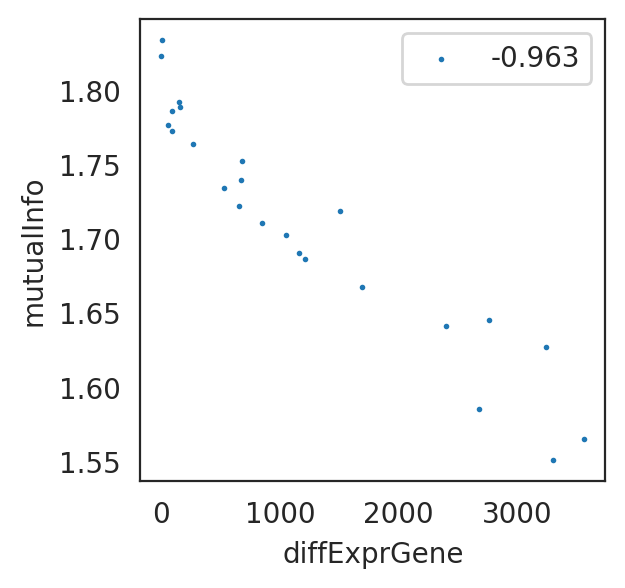

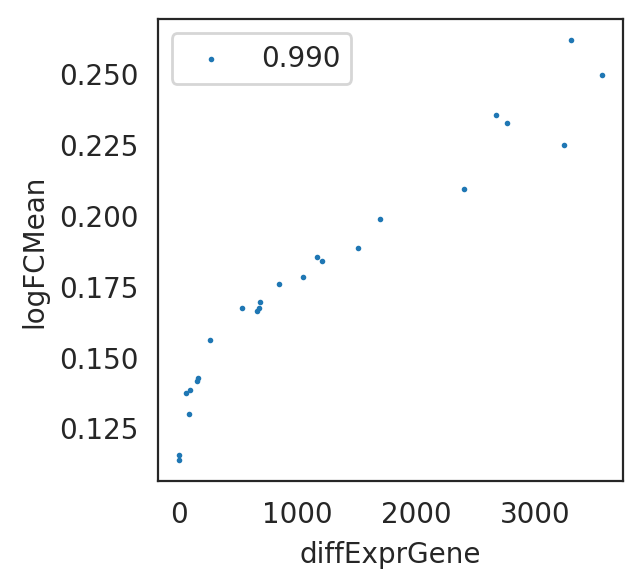

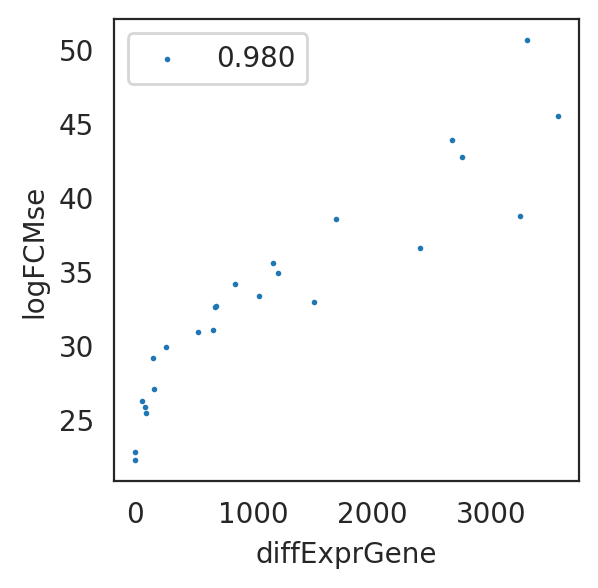

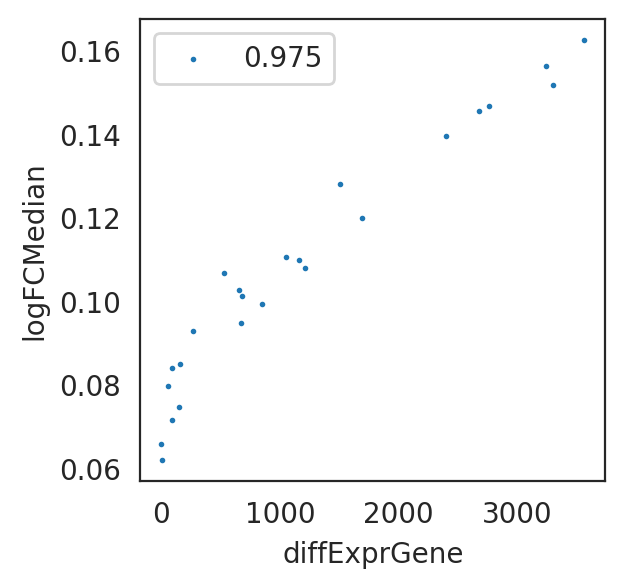

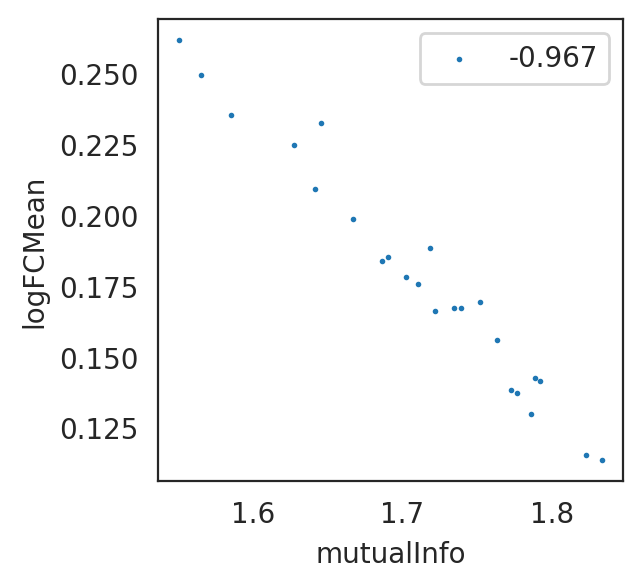

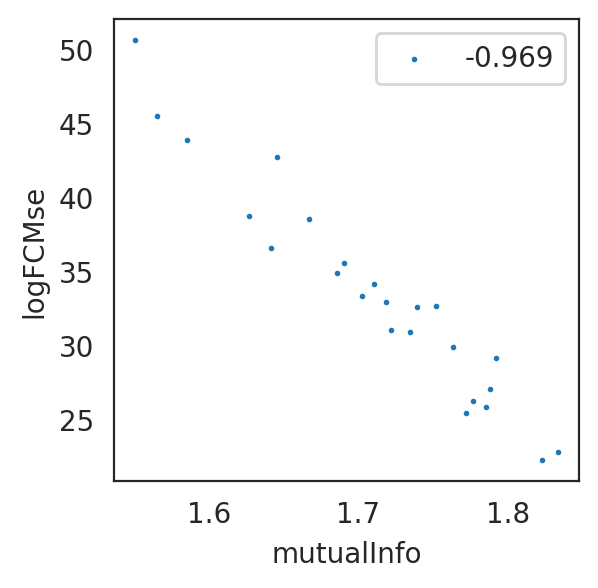

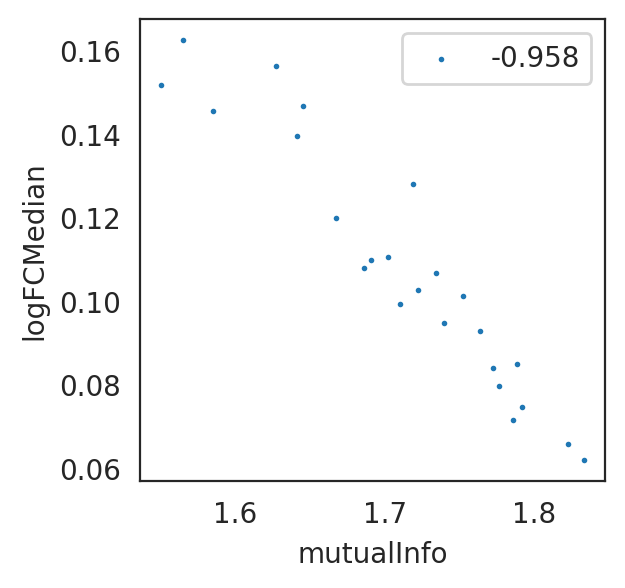

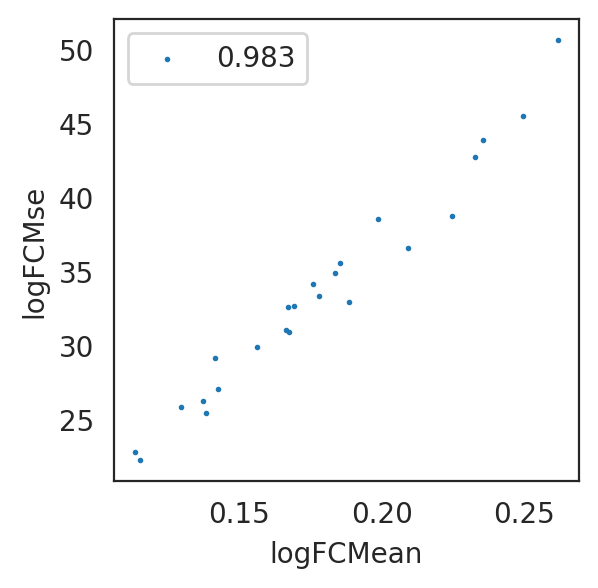

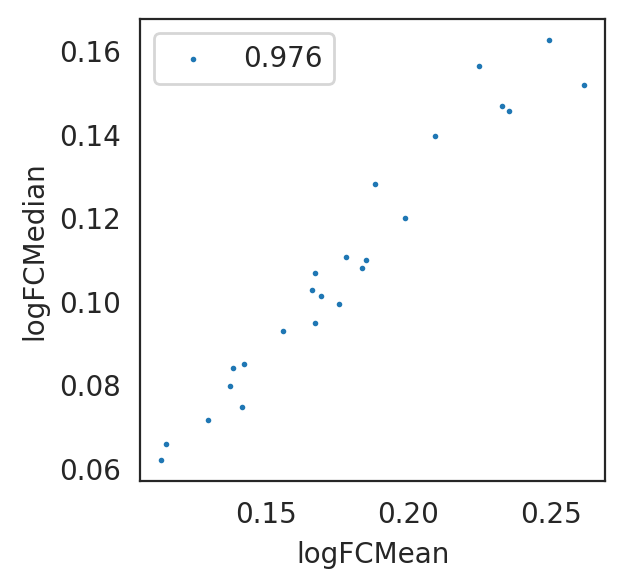

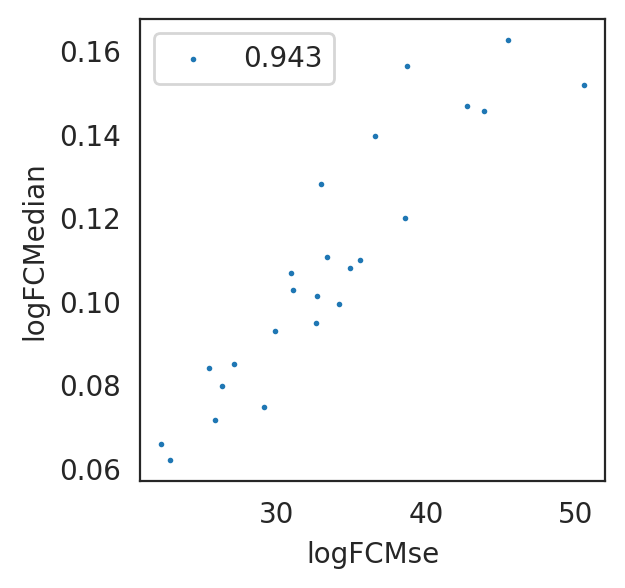

In [47]:
def checkMetricCorrelation(metric1: np.ndarray, metric2: np.ndarray, n1: str, n2: str): 
    plt.figure(figsize=(3,3))
    plt.scatter(metric1, 
                metric2, 
                s=1, 
                label=f"{spearmanr(metric1, metric2)[0]:.3f}")
    plt.xlabel(n1)
    plt.ylabel(n2)
    plt.legend()
    plt.show()
    
listOfMetrics = ["diffExprGene", "mutualInfo", "logFCMean", "logFCMse", "logFCMedian"]
for (p1, p2) in it.combinations(listOfMetrics, r=2):
    checkMetricCorrelation(eval(p1), eval(p2), p1, p2)

In [48]:
"""
Downloaded from http://humantfs.ccbr.utoronto.ca/download.php """
TFList = pd.read_csv("setup/tfList.csv", index_col=0).iloc[:, [1,3]]
TFDict = dict([tuple(i) for i in TFList.to_numpy().tolist() if i[1] == 'Yes'])

"""
Downloaded from https://epifactors.autosome.org/description """
EpiList = pd.read_csv("setup/epiList.csv", index_col=0).iloc[:, [0,14]]
EpiDict = dict([tuple(i) for i in EpiList.to_numpy().tolist()])

perturbagenList = np.array(sorted(set(expression_quantified.obs.perturbation) - set(controls)))
perturbagenStatus = np.array(["Yes" if p in TFDict or p in EpiDict else "No" for p in perturbagenList])
colorDict = {'No': '#1f77b4', 'Yes': '#ff7f0e'}
perturbagenColor = [colorDict[p] for p in perturbagenStatus]

['MED12', 'CBFB', 'TNFAIP3', 'IL2RA', 'PTEN', 'JAK3']


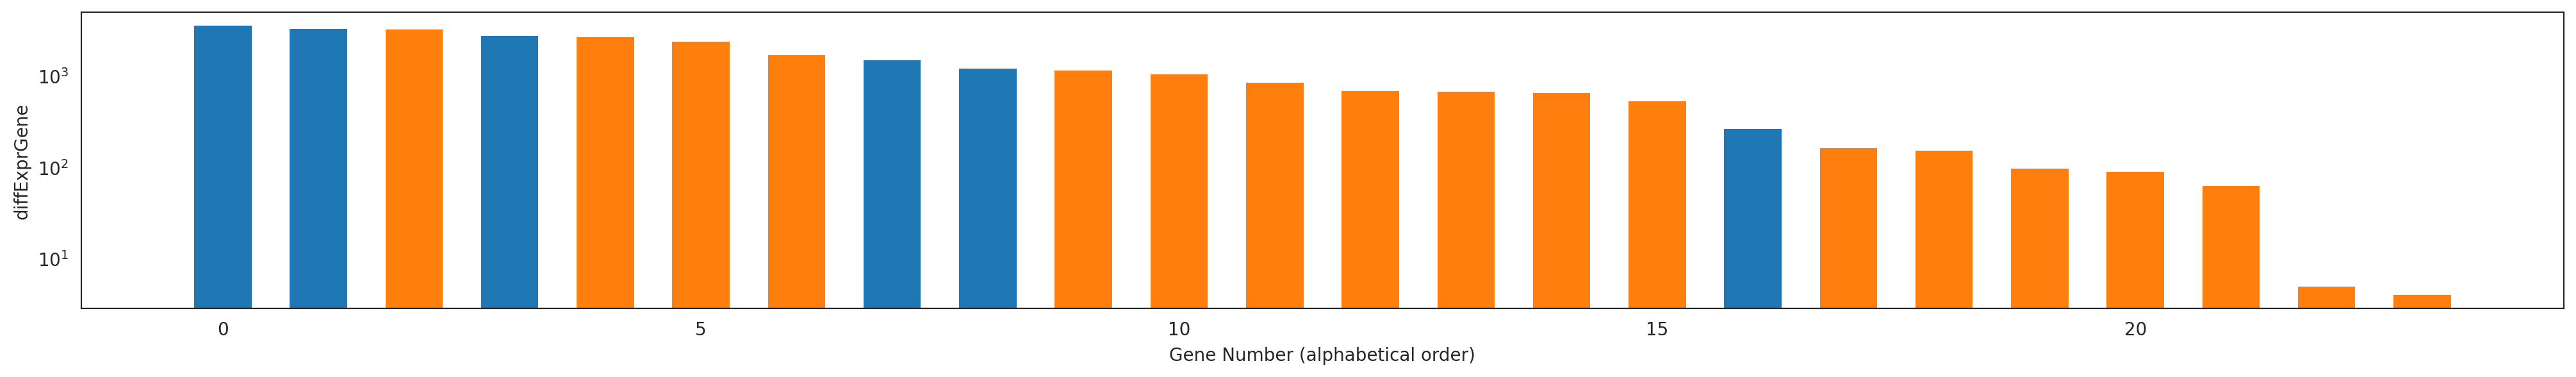

['CBFB', 'MED12', 'TNFAIP3', 'PTEN', 'IL2RA', 'JAK3']


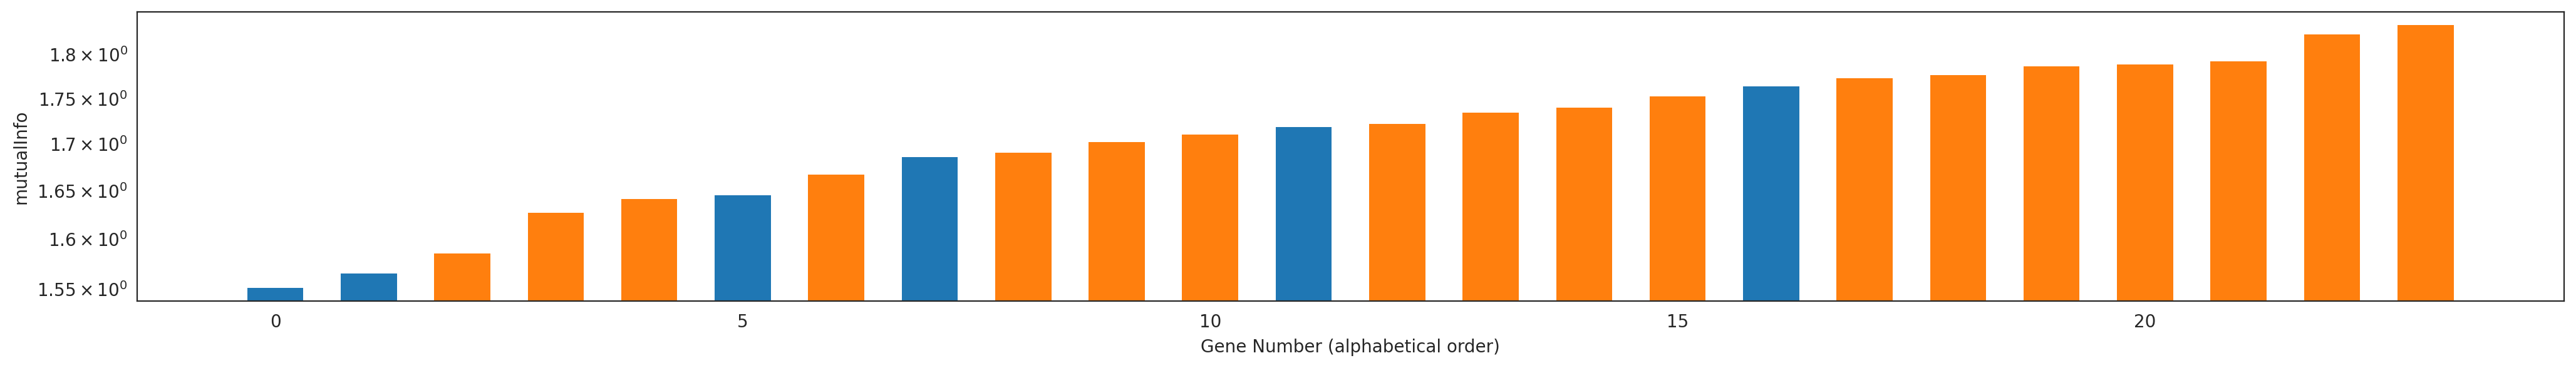

['CBFB', 'MED12', 'TNFAIP3', 'IL2RA', 'PTEN', 'JAK3']


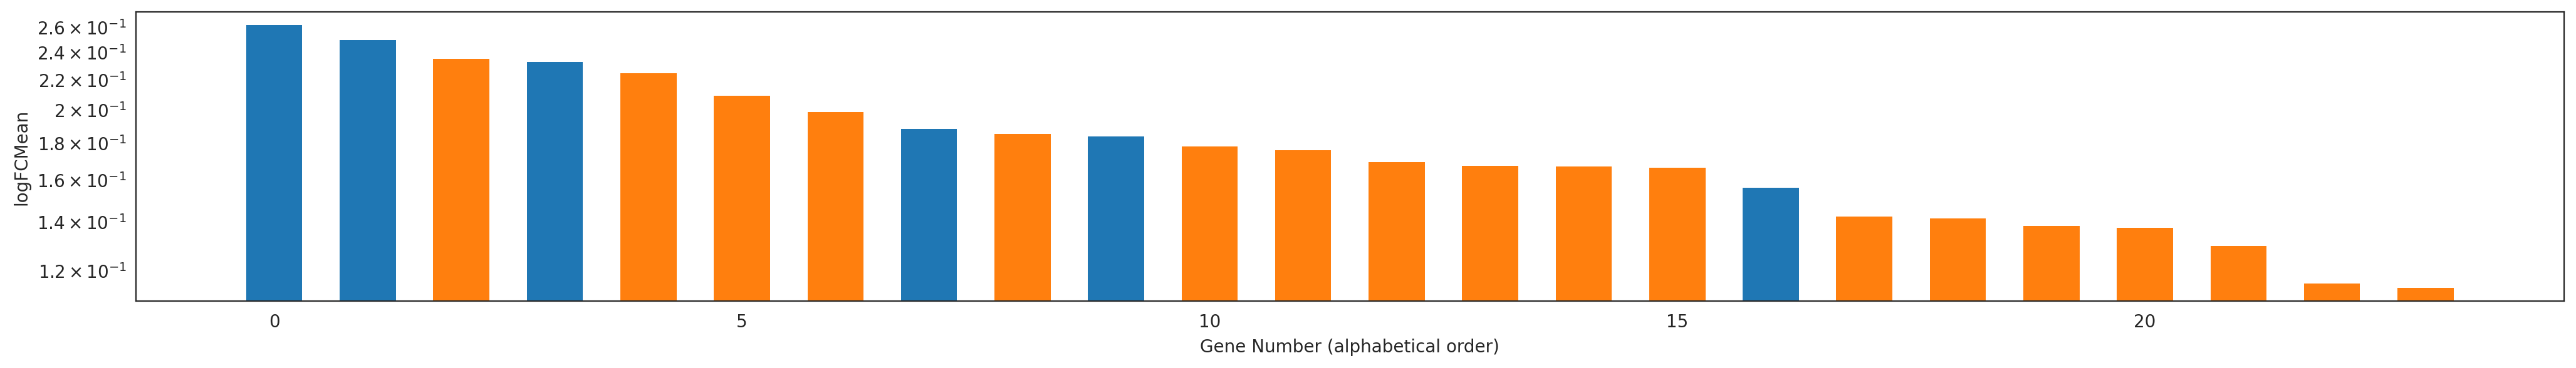

['CBFB', 'MED12', 'TNFAIP3', 'PTEN', 'IL2RA', 'JAK3']


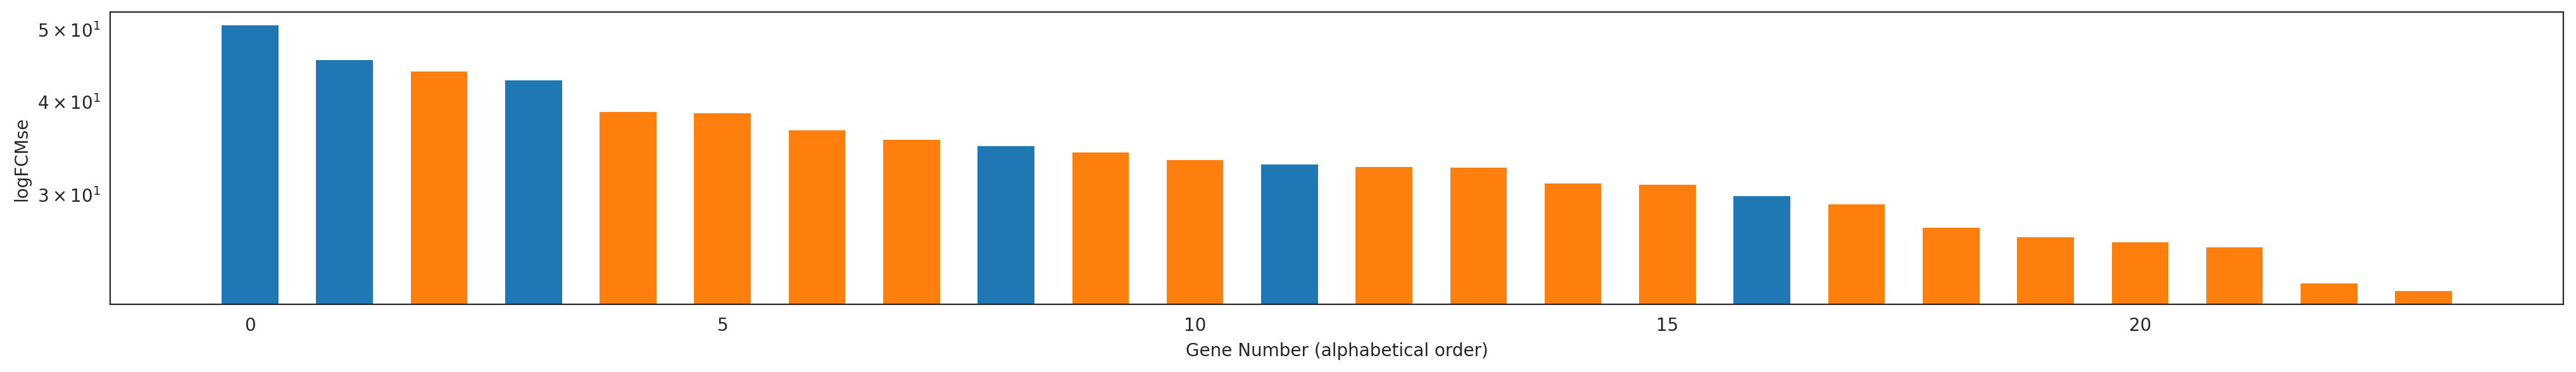

['MED12', 'CBFB', 'TNFAIP3', 'IL2RA', 'PTEN', 'JAK3']


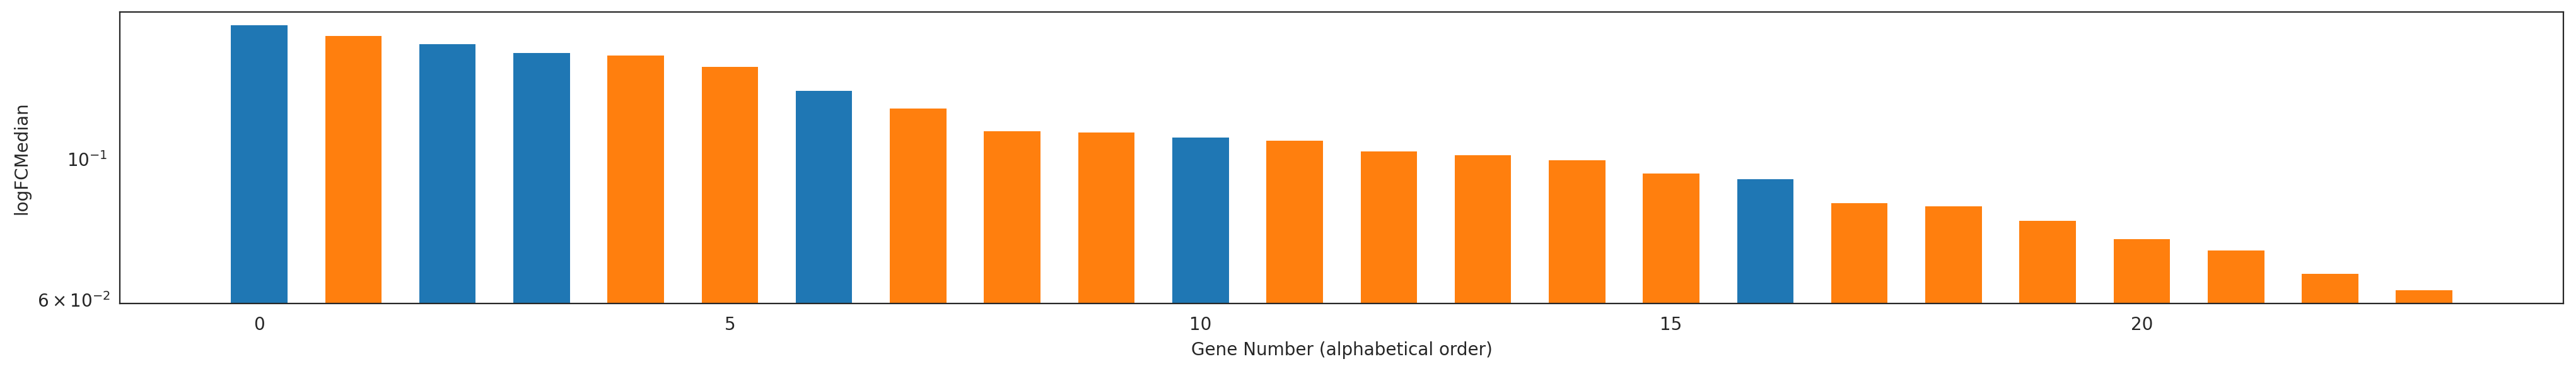

In [49]:
for idx, p1 in enumerate(listOfMetrics):
    plt.figure(figsize=(25,3))
    index = np.argsort(eval(p1))[::-1]
    if idx == 1:
        index = index[::-1]
    # if idx == 0:
    #     index = [np.where(np.array(perturbs)==i)[0][0] for i in goldStandard]
    plt.bar(np.arange(diffExprGene.shape[0]), eval(p1)[index], width=0.6, 
            linewidth=0, color=np.array(perturbagenColor)[index], log=True)
    print([p for i,p in enumerate(perturbagenList[index]) if perturbagenStatus[index][i] == 'No'])
    plt.ylabel(f"{p1}")
    plt.xlabel("Gene Number (alphabetical order)")
    plt.show()

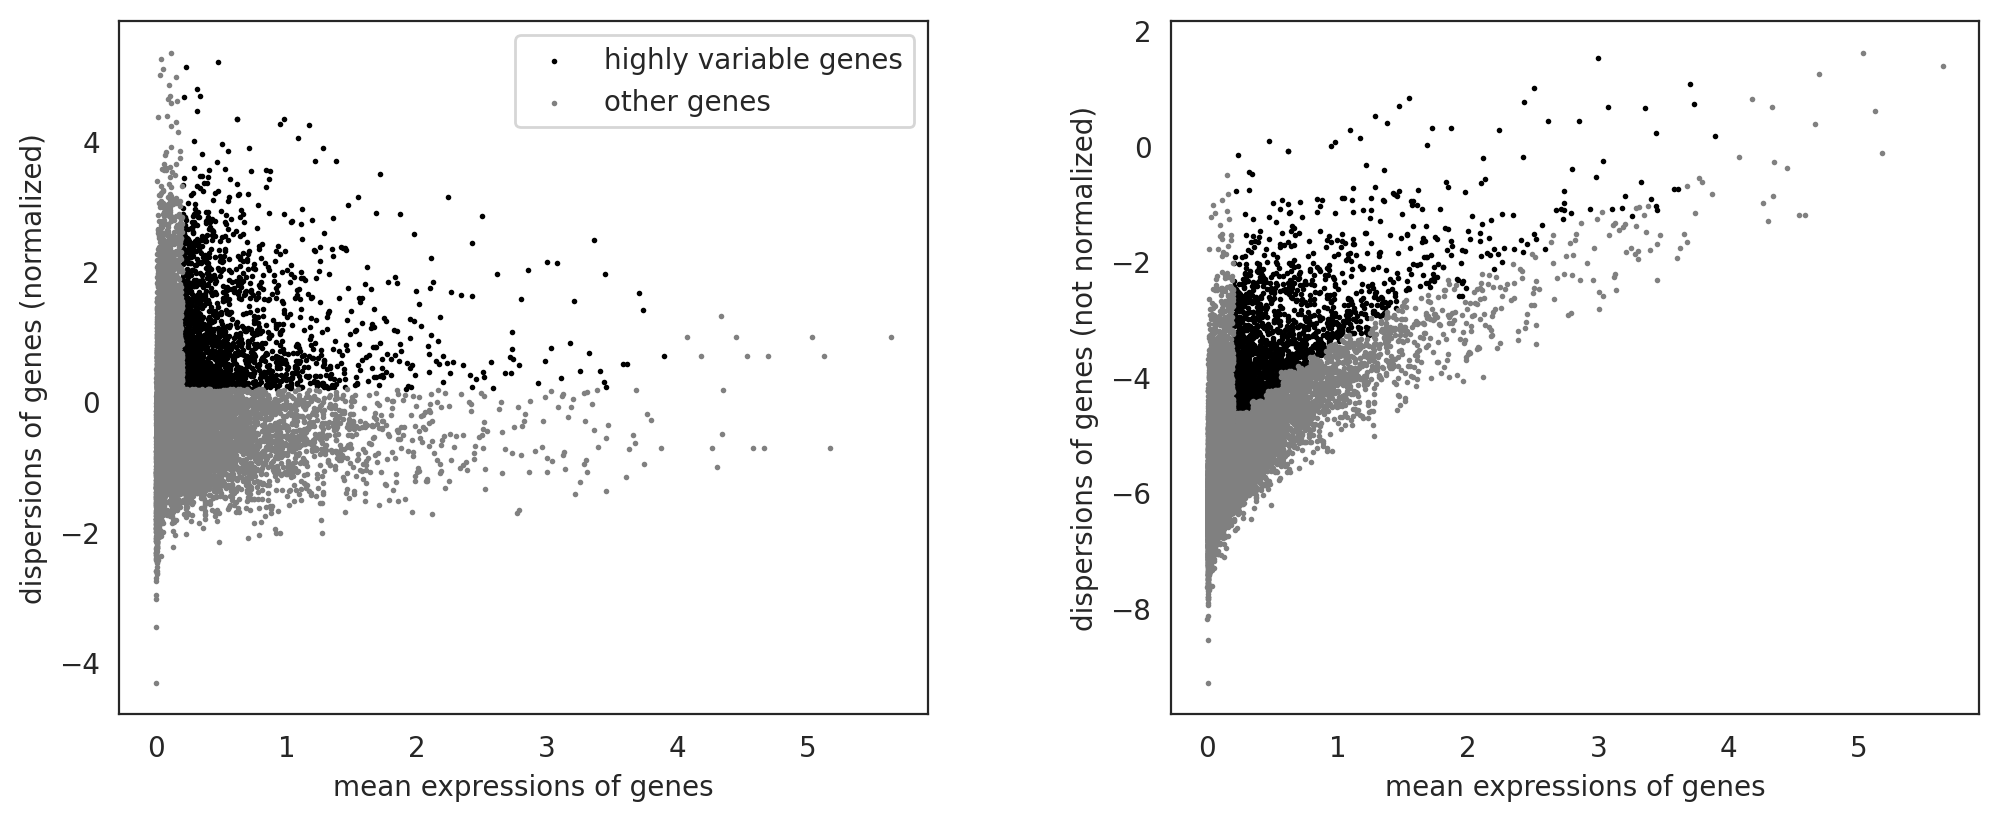

In [50]:
sc.pp.normalize_total(expression_quantified, target_sum=1e4)
sc.pp.log1p(expression_quantified)
sc.pp.highly_variable_genes(expression_quantified, min_mean=0.2, max_mean=4, min_disp=0.2, n_bins=50)
sc.pl.highly_variable_genes(expression_quantified)
with warnings.catch_warnings():
    sc.tl.pca(expression_quantified, n_comps=5)
sc.pp.neighbors(expression_quantified)
sc.tl.umap(expression_quantified)
clusterResolutions = []
sc.tl.leiden(expression_quantified)

In [51]:
expression_quantified.var_names

Index(['MTND1P23', 'MTND2P28', 'MTCO1P12', 'MTCO2P12', 'MTATP8P1', 'MTATP6P1',
       'MTCO3P12', 'LINC01409', 'AL669831.4', 'LINC01128',
       ...
       'MT-ND4L', 'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6',
       'MT-CYB', 'MT-TT', 'MT-TP'],
      dtype='object', length=14299)

In [52]:
"CTLA4" in set(expression_quantified.var.index)

True

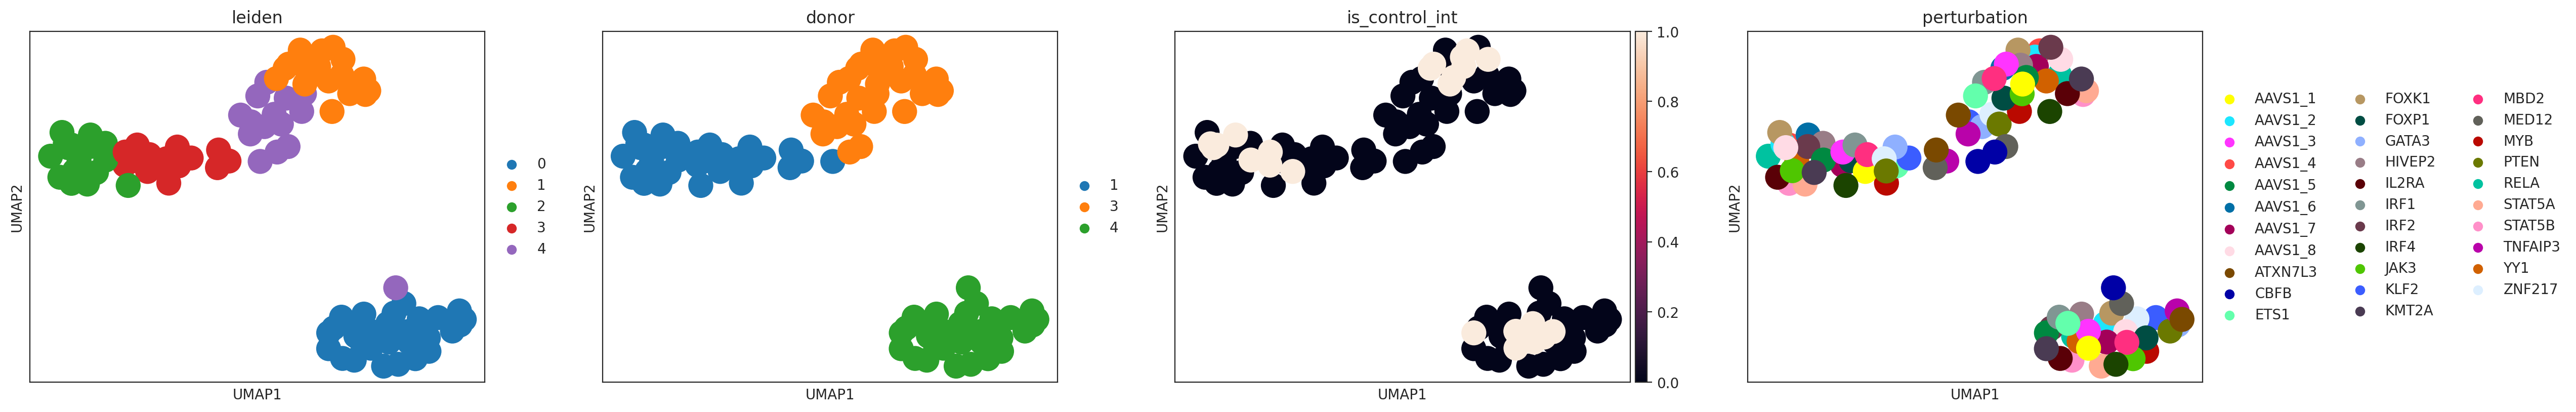

Some plots are missing due to a weird scanpy KeyError on genes "IL2RA", "IL2", "CTLA4".


<Figure size 2061x450 with 0 Axes>

In [20]:
sc.pl.umap(expression_quantified, color = ["leiden", "donor", "is_control_int", "perturbation"])
try:
    sc.pl.umap(expression_quantified, color = ["IL2RA", "IL2", "CTLA4"])
except KeyError:
    print('Some plots are missing due to a weird scanpy KeyError on genes "IL2RA", "IL2", "CTLA4".')
# Due to the small number of samples, ask CO to use only one cluster.
# Requires setting certain other undocumented aspects of object state. :(
expression_quantified.obs["fake_cluster"]="all_one_cluster"
expression_quantified.obs.fake_cluster = expression_quantified.obs.fake_cluster.astype("category")
expression_quantified.uns["fake_cluster_colors"] = ['#1f77b4']

### Data reduction

With only 64GB of RAM, I have been unable to make whole-transcriptome predictions with CellOracle. A data reduction step is necessary where only highly variable genes are included. We also keep all genes that are perturbed, whether or not they appear highly variable -- unless they are unavailable in the first place. 

In [53]:
perturbed_genes = set(list(expression_quantified.obs['perturbation'].unique())).difference(controls)
perturbed_and_measured_genes = perturbed_genes.intersection(expression_quantified.var.index)
perturbed_but_not_measured_genes = perturbed_genes.difference(expression_quantified.var.index)
genes_keep = expression_quantified.var.index[expression_quantified.var['highly_variable']]
genes_keep = set(genes_keep).union(perturbed_and_measured_genes)
expression_quantified_orig = expression_quantified.copy()
print("These genes were perturbed but not measured:")
print(perturbed_but_not_measured_genes)
print("This many variable genes will be kept and used by CO:")
print(len(genes_keep))

These genes were perturbed but not measured:
set()
This many variable genes will be kept and used by CO:
1865


In [54]:
# final form, ready to save
expression_quantified = expression_quantified_orig[:,list(genes_keep)]
expression_quantified.uns["perturbed_and_measured_genes"]     = list(perturbed_and_measured_genes)
expression_quantified.uns["perturbed_but_not_measured_genes"] = list(perturbed_but_not_measured_genes)
expression_quantified = ingestion.describe_perturbation_effect(expression_quantified, "knockout")

In [55]:
os.makedirs("perturbations/freimer", exist_ok = True)
expression_quantified.write_h5ad("perturbations/freimer/test.h5ad")